In [1]:
import nlcc
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
base_colors = ["e63946","f1faee","a8dadc","457b9d","1d3557"]
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [4]:
df.groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,12,12,12,12,12
cheminf,10,10,10,10,10
genchem,11,11,11,11,11
md,8,8,8,8,8
plot,10,10,10,10,10
qm,6,6,6,6,6
sim,4,4,4,4,4
spectroscopy,6,6,6,6,6
stats,9,9,9,9,9


## Programmatic Prompts

In [5]:
paths = ' '.join(valid_files)
temperatures = [0.05, 0.2, 0.5]
k = 5
for i,t in enumerate(temperatures):    
    out = f'override_bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --prompt python --temperature $t
    out = f'bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --temperature $t        
    out = f'insert_bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --prompt insert --temperature $t
    out = f'cheader_bench_{i}.csv'
    header = 'header:# MIT License\n\n# Copyright (c) 2022 Regents of the University of California\n\n'
    !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t
    out = f'lheader_bench_{i}.csv'
    header = 'header:# This is written by an expert Python programmer\n\n'
    !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t

../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectra

../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
name 'IMP' is not defined
name 'IMP' is not defined
name 'PDBFile' is not defined
name 'IMP' is not defined
name 'IMP' is not defined
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_3d_sin/plot_3d_s

'NoneType' object has no attribute 'text'
invalid syntax (<string>, line 73)
invalid syntax (<string>, line 89)
../data/bravais/bravais.yml
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
../data/canonicalize/canonicalize.yml
2021.03.2
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
2021.03.2
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
2021.03.2
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
2021.03.2
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
2021.03.2
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'Element' object has no attribute 'pauling_electronegativity'
'Element' object has no attribute 'pauling_electronegativity'
../data/descriptors

../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
name 'itertools' is not defined
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
name 'itertools' is not defined
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
name 'itertools' is not defined
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot

../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
d =  0
d =  0
d =  0
d =  0
d =  0
../data/element_mass/element_mass.yml
Missing parentheses in call to 'print'. Did you mean print("Error: element mass not found for element symbol:", element_symbol)? (<string>, line 12)
Missing parentheses in call to 'print'. Did you mean print("Error: element mass not found for element symbol:", element_s

../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot

../data/unbdistance/unbdistance.yml
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
spec

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), 

../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
../data/blast/blast.yml
invalid syntax (<string>, line 102)
list index out of range
list index out of range
cannot unpack non-iterable NoneType object
'NoneType' object has no attribute 'text'
../data/bravais/bravais.yml
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 13)
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccn

../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
atom_pairs must be ndim 2. You supplied 1
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../dat

../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101905259789.269
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
../data/blast/blast.yml
invalid syntax (<string>, line 73)
module 'urllib' has no attribute 'urlencode'
No module named 'urllib2'
No module named 'urllib2'
invalid syntax (<string>, line 102)
../data/bravais/bravais.yml
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
../data/canonicalize/canonicalize.yml
name 'Chem' is not defined
name 'Chem' is not defined
n

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_correlation_coefficient/plot_correlation.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_dual_axis/plot_dual_axis.yml
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
../data/plot_emoji/plot_emoji.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_outside_legend/plot_outside_legend.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_scatter_pointsize/plot_pointsize.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_sin/plot_sin.yml
name 'np' is not defined
name 'np' is not defined
name 

../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'Element' object has no attribute 'pauling_en'
'Element' object has no attribute 'pauling_en'
'Element' object has no attribute 'pauling_en'
../data/descriptors/descriptors.yml
2021.03.2
2021.03.2
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
2021.03.2
2021.03.2
2021.03.2
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
2021.03.2
d =  0
2021.03.2
Python argument types i

../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
name 'itertools' is not defined
1.9.5
int() argument must be a string, a bytes-like object or a number, not 'Residue'
1.9.5
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
<string>:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3

atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spect

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
'list' object has no attribute 'masses'
'list' object has no attribute 'masses'
'list' object has no attribute 'masses'
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
'list' object has no attribute 'masses'
../data/max-boltz/max-boltz.yml
../data/mc_harmonic/mc_harmonic.yml
../data/mc_isi

../data/unbdistance/unbdistance.yml
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
atom_pairs must be ndim 2. You supplied 3
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
s

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
on

['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling_en'
'Element' object has no attribute 'pauling_electronegativity'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
tuple index out of

../data/plot_3d_sin/plot_3d_sin.yml
Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.
../data/plot_bar/plot_bar.yml
s must be a scalar, or float array-like with the same size as x and y
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
../

name 'get_descriptors_for_smiles' is not defined
name 'Chem' is not defined
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
unsupported operand type(s) for -: 'float' and 'NoneType'
The dipole moment is: [0.0758602 0.        0.0504284]
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/dou/dou.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/element_mass/element_mass.yml
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn

../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling_electronegativity'
../data/descriptors/descriptors.yml
2021.03.2
name 'get_mol_descriptors' is not defined
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
unsupported operand type(s) for -: 'float' and 'NoneType'
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/dou/dou.yml
2021.03.2
d =  0
2021.03.2
d =  -1.0
2021.03.2
d =  None
2021.03.2
'str' object has no attribute 'GetAtoms'
2021.03.2
d =  0
../data/element_mass/element_mass.yml
argument of type 'function' is not iterable
../data/element_name

../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
local variable 's' referenced before assignment
string index out of range
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

../data/osmotic_pressure/osmotic_pressure.yml
../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
1.9.5
atom_pairs must be ndim 2. You supplied 1
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.93480220054467

Extra cycle  E= -98.570489739001  delta_E=    0  |g|= 3.73e-09  |ddm|= 5.29e-08
converged SCF energy = -98.570489739001
My result: -98.57048973900099
nlcc result: -98.57048973900096
1.7.6
converged SCF energy = -98.570489739001
My result: -98.57048973900096
nlcc result: None
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/qed/qed.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/quantile/quantile.yml
operands could not be broadcast together with shapes (300,) (3,) 
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/random_walk/random_walk.yml
expected x and y to have same length
expected x and y to have same length
expected x and y to have same length
expected x and y to have same length
../data/rm-water/remove-water.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/rmse/rmse.yml
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
1.9.5
/home/whi

Missing parentheses in call to 'print'. Did you mean print('Element ', element_symbol, ' not found in table')? (<string>, line 21)
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Topology' object has no attribute 'atom_name'
../data/force-const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
could not convert string to float: 'Bilbao Crystallographic Server  Generators of Space Groups'
list index out of range
list index out of range
list index out of range
too many indices for array: array is 1-dimensional, but 2 were index

../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
Unrecognized marker style '😀'
<string>:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😊'
Unrecognized marker style '😀'
<string>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
../data/plot_outside_legend/plot_outside_legend.yml
'Rectangle' object has no property 'normed'
'Rectangle' object has no property 'normed'
../data/plot_scatter_pointsize/plot_pointsize.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
../data/plot_sin/plot_sin.yml
/home/whitead/miniconda3/envs/nlcc/

'Element' object has no attribute 'pauling_en'
'function' object is not subscriptable
../data/descriptors/descriptors.yml
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(str, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
'str' object has no attribute 'GetAtoms'
d =  0
d =  0
'str' object has no attribute 'mol'
module 'rdkit.Chem.Descriptors' has no attribute 'NumCarbon'
../data/element_mass/element_mass.yml
'funct

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
Missing parentheses in call to 'print'. Did you mean print("Energy = %8.4f Hartrees" % energy)? (<string>, line 54)
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
'list' object has no attribute 'shape'
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
operands could not be broadcast togeth

../data/arrhenius/arrhenius.yml
math range error
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 22308585052231.824
spectral radiance = 7084846043273.869
spectral radiance from codex = 23622.42538591459
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101905259789.269
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
../data/blast/blast.yml
list index out of range
list index out of range
list index out of range
No module named 'rpy2'
BLAST search failed
not enough values to unpack (expected 2, got 0)
../data/bravais/bravais.yml
invalid syntax (<string>, line 33)
No known Bravais lattice for space group 47
invalid syntax (<string>, line 48)
invalid syntax (<string>, line 47)
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['

Missing parentheses in call to 'print'. Did you mean print("Usage: python %s <T> <M>" % sys.argv[0])? (<string>, line 19)
../data/mc_harmonic/mc_harmonic.yml
<string>:24: RuntimeWarning: invalid value encountered in double_scalars
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcFormalCharge'
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
../data/osmotic_pressure/osmotic_pressure.yml
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/en

atom_pairs must be ndim 2. You supplied 3
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


In [6]:
merged = None
for i,t in enumerate(temperatures):
    f = f'override_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = 'none'
    if merged is None:
        merged = bf
    else:
        merged = pd.concat((merged, bf))
    f = f'bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    merged = pd.concat((merged, bf))
    f = f'insert_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
    f = f'cheader_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
    f = f'lheader_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
def simple_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'
    
merged = merged.assign(used_context=merged.context.apply(simple_context))
merged.to_pickle('promp_results.pkl')
merged.tail()

,name,result,temperature,language,context,topic,type,natlang,used_context
425,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
426,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
427,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
428,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
429,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority


/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


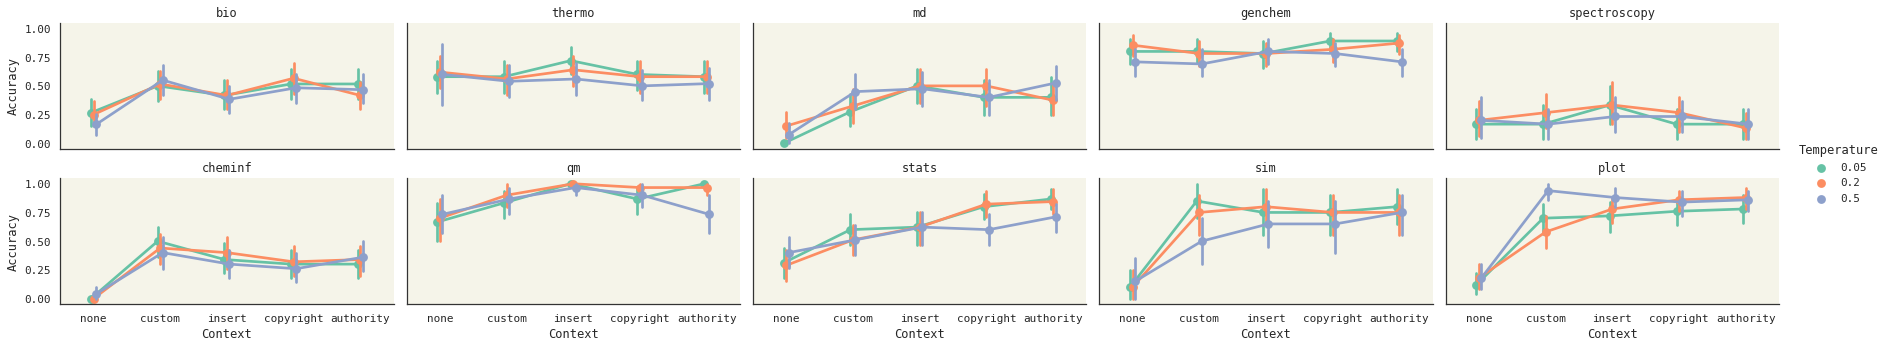

In [7]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='topic', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('accuracy.pdf')

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


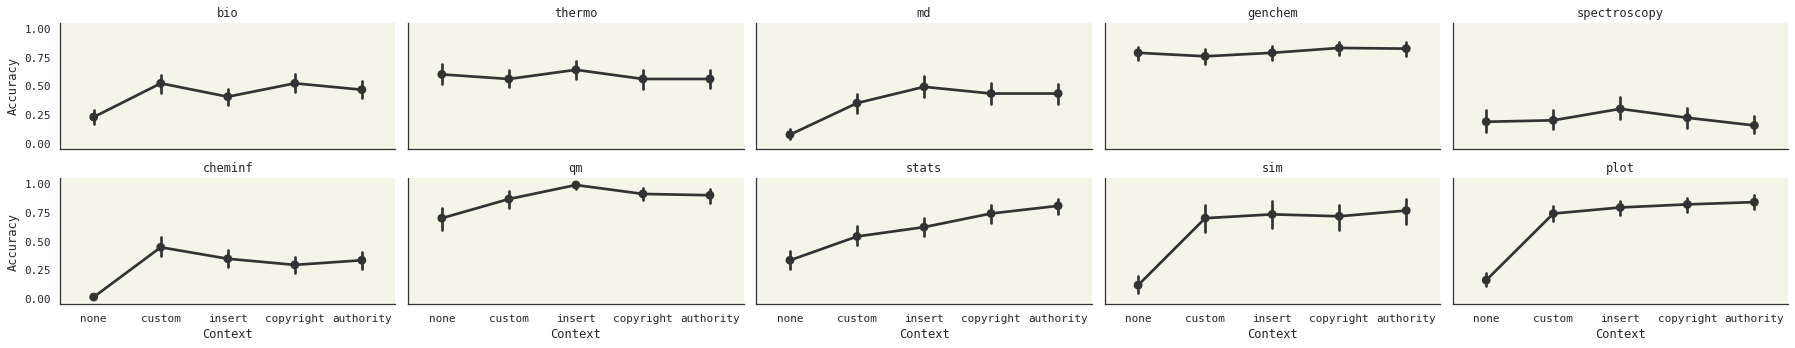

In [14]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='topic',  col_wrap=5, height=2.5, aspect=2)
g.map(sns.pointplot, 'used_context', 'result', dodge=True, color='#333')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('marginal_accuracy.pdf')

In [9]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    12 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &     8 \\
plot         &    10 \\
qm           &     6 \\
sim          &     4 \\
spectroscopy &     6 \\
stats        &     9 \\
thermo       &    10 \\
\bottomrule
\end{tabular}



/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


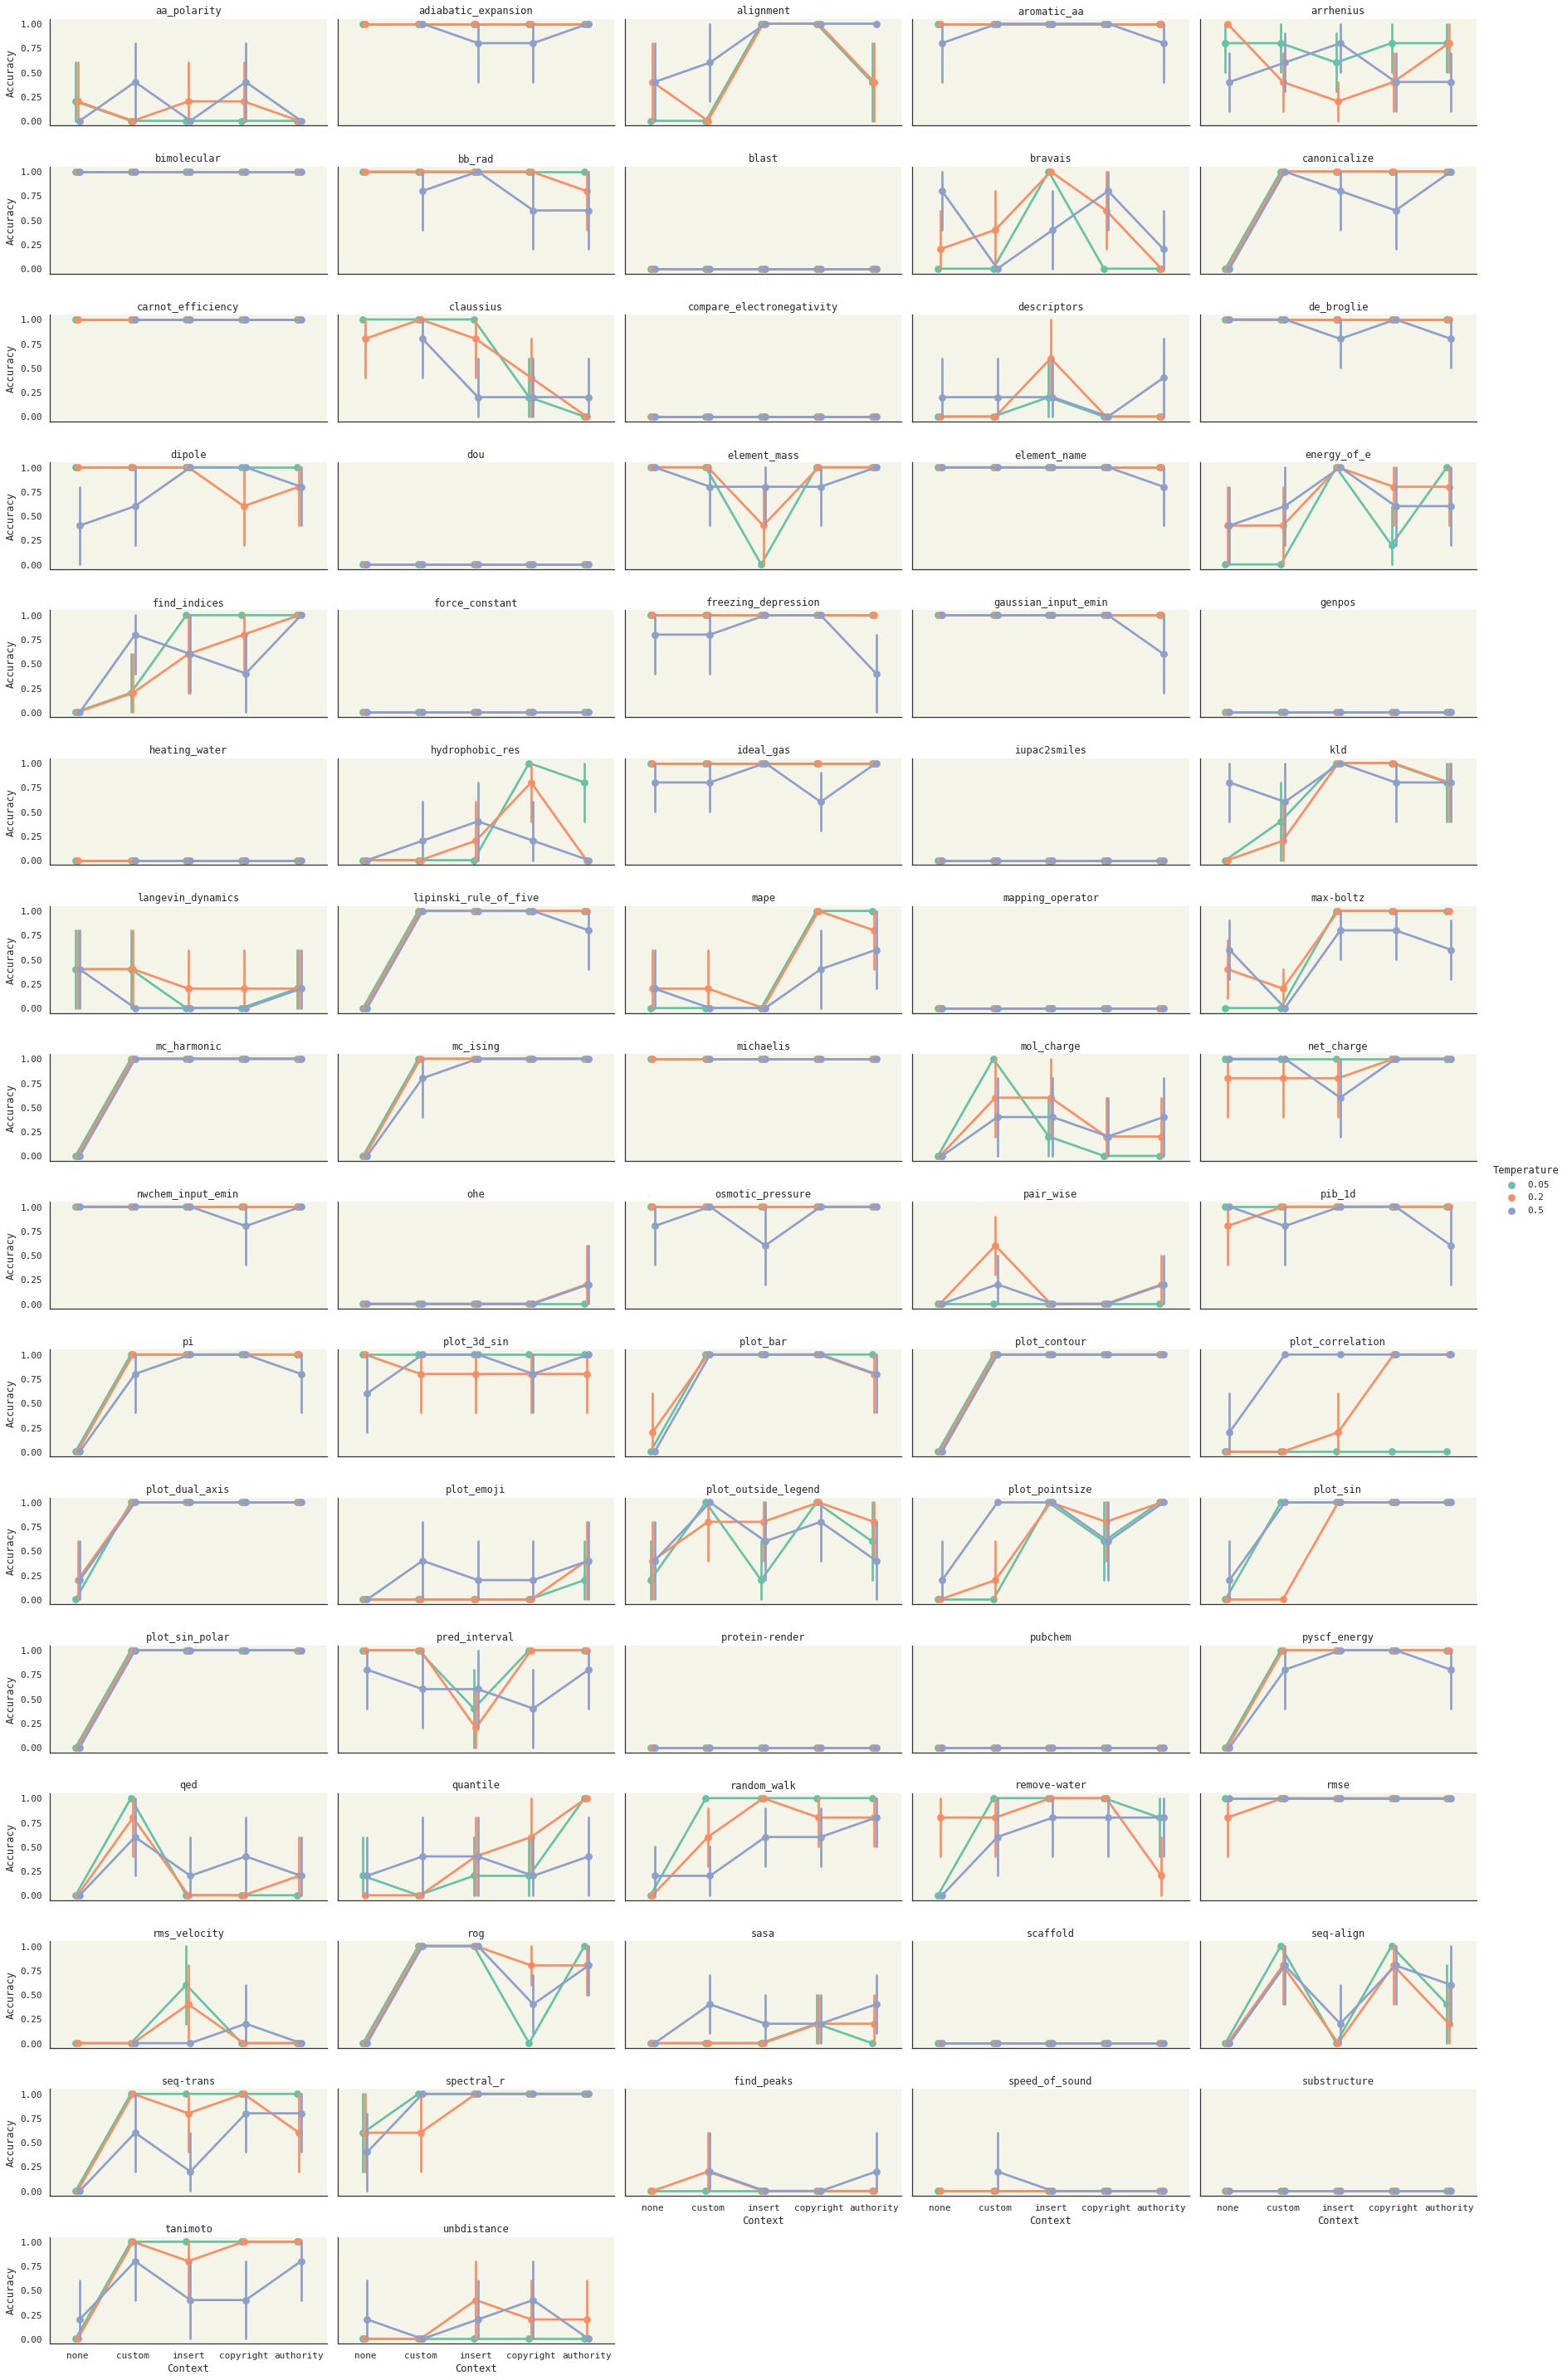

In [10]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('all.pdf')

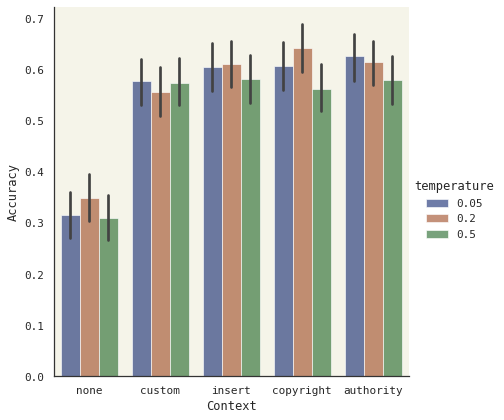

In [11]:
g = sns.catplot(
    data=merged, kind="bar",
    x="used_context", y="result", hue="temperature",
    palette="dark", alpha=.6, height=6
)
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('Context Choice')
g.savefig('context.pdf')